<h2>1. Import the necessary library</h2>

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint




In [7]:
# Konfigurasi Dasar
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 50 # Anda bisa ubah ke 50 atau 100 jika hasil belum konvergen
LEARNING_RATE = 0.0001 # LR lebih kecil agar aman untuk Transfer Learning

<h2>2. Load dataset</h2>

In [8]:
# Direktori Dataset 
train_dir = 'Dataset/train'
val_dir = 'Dataset/val'
test_dir = 'Dataset/test'

# Augmentasi untuk Data Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20 # Tambahan: rotasi membantu model lebih robust
)

# Rescale saja untuk Val dan Test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data:")
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Test Data:")
# PENTING: shuffle=False agar urutan label sesuai untuk evaluasi sklearn
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan nama kelas
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Kelas terdeteksi: {class_names}")

Loading Training Data:
Found 4800 images belonging to 4 classes.
Loading Validation Data:
Found 1600 images belonging to 4 classes.
Loading Test Data:
Found 1600 images belonging to 4 classes.
Kelas terdeteksi: ['defect', 'longberry', 'peaberry', 'premium']


<h2>3. Define the model</h2>

In [9]:
def build_model(model_type, input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    if model_type == 'custom_cnn':
        # Arsitektur Original Anda (sedikit dirapikan)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x) # Dropout dinaikkan agar tidak overfitting
        x = Dense(256, activation='relu')(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs, outputs, name="Custom_CNN")
        
    elif model_type == 'mobilenetv2':
        # Preprocessing: Ubah range [0,1] ke [-1,1]
        x_rescaled = Rescaling(scale=2.0, offset=-1.0)(inputs)
        
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_rescaled)
        base_model.trainable = False # Freeze bobot asli
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x) # Pengganti Flatten yg lebih efisien
        x = Dropout(0.3)(x)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs, outputs, name="MobileNetV2")
        
    elif model_type == 'resnet50v2':
        # Preprocessing: Ubah range [0,1] ke [-1,1]
        x_rescaled = Rescaling(scale=2.0, offset=-1.0)(inputs)
        
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=x_rescaled)
        base_model.trainable = False # Freeze bobot asli
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs, outputs, name="ResNet50V2")
        
    else:
        raise ValueError("Tipe model tidak dikenali")

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# <h2>4. Compile and train the model</h2>

## Custom CNN

In [10]:
m_type = 'custom_cnn'
print(f"\n{'='*40}")
print(f" TRAINING MODEL: {m_type.upper()} ")
print(f"{'='*40}")

# 1. Build Model
model = build_model(m_type, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)


 TRAINING MODEL: CUSTOM_CNN 


In [11]:
model.summary() # Optional: nyalakan jika ingin melihat arsitektur

Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,140 (32.36 MB)

 Trainable params: 8,483,140 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 2. Train Model
print("Memulai training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

Memulai training...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 651ms/step - accuracy: 0.3504 - loss: 1.3438 - val_accuracy: 0.4181 - val_loss: 1.2612
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 288ms/step - accuracy: 0.4856 - loss: 1.1525 - val_accuracy: 0.3231 - val_loss: 1.4119
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.5558 - loss: 1.0518 - val_accuracy: 0.4969 - val_loss: 1.0960
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.6215 - loss: 0.9287 - val_accuracy: 0.5288 - val_loss: 1.0574
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.6569 - loss: 0.8571 - val_accuracy: 0.5750 - val_loss: 0.9654
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.6781 - loss: 0.7890 - val_accuracy: 0.5906 - val_loss: 0.9567
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.7100 - loss: 0.7364 - val_accuracy: 0.6550 - val_loss: 0.8603
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accura

In [13]:
history_df = pd.DataFrame(history.history)
csv_name = f"history_{m_type}.csv"
history_df.to_csv(csv_name, index=False)
print(f"📈 History training berhasil disimpan ke: {csv_name}")

📈 History training berhasil disimpan ke: history_custom_cnn.csv


In [14]:
# 3. Save Model (.keras)
save_path = f"model_{m_type}.keras"
model.save(save_path)
print(f"💾 Model berhasil disimpan ke: {save_path}")

💾 Model berhasil disimpan ke: model_custom_cnn.keras


In [15]:
# 4. Evaluasi
print(f"\nEvaluasi Model {m_type} pada Data Test...")
test_generator.reset()
Y_pred = model.predict(test_generator, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))


Evaluasi Model custom_cnn pada Data Test...

Classification Report:
              precision    recall  f1-score   support

      defect       0.77      0.74      0.76       400
   longberry       0.75      0.95      0.84       400
    peaberry       0.90      0.78      0.83       400
     premium       0.73      0.67      0.70       400

    accuracy                           0.78      1600
   macro avg       0.79      0.78      0.78      1600
weighted avg       0.79      0.78      0.78      1600



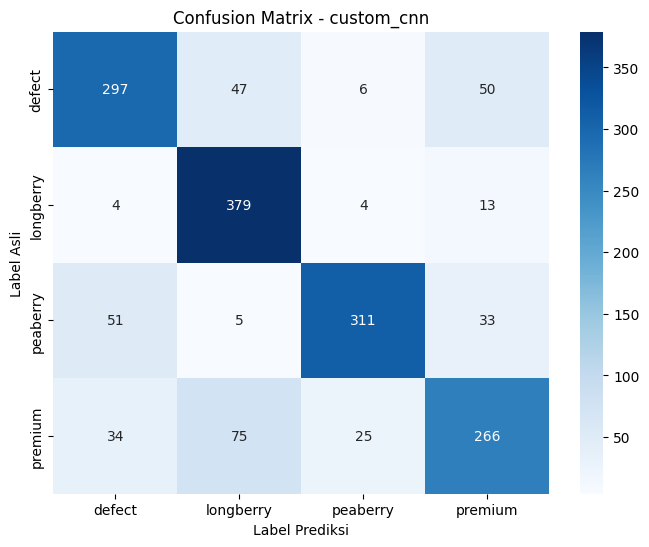

In [16]:
# Plot Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.title(f'Confusion Matrix - {m_type}')
plt.show()

## Mobilenetv2

In [17]:
# --- KONFIGURASI KHUSUS CELL INI ---
m_type = 'mobilenetv2'
print(f"\n{'='*40}")
print(f" TRAINING MODEL: {m_type.upper()} ")
print(f"{'='*40}")

# 1. Build Model
model = build_model(m_type, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)


 TRAINING MODEL: MOBILENETV2 


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13716\53245689.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_rescaled)


In [18]:
model.summary()

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# 2. Train Model
print("Memulai training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

Memulai training...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.5104 - loss: 1.2407 - val_accuracy: 0.6275 - val_loss: 0.8746
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.6475 - loss: 0.8824 - val_accuracy: 0.6587 - val_loss: 0.8304
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - accuracy: 0.6888 - loss: 0.7832 - val_accuracy: 0.6869 - val_loss: 0.7940
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.7146 - loss: 0.7273 - val_accuracy: 0.6712 - val_loss: 0.8209
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.7454 - loss: 0.6731 - val_accuracy: 0.7219 - val_loss: 0.6988
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.7471 - loss: 0.6485 - val_accuracy: 0.7294 - val_loss: 0.6973
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - accuracy: 0.7675 - loss: 0.6283 - val_accuracy: 0.7150 - val_loss: 0.7354
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accura

In [20]:
# --- BAGIAN BARU: SIMPAN HISTORY KE CSV ---
history_df = pd.DataFrame(history.history)
csv_name = f"history_{m_type}.csv"
history_df.to_csv(csv_name, index=False)
print(f"📈 History training berhasil disimpan ke: {csv_name}")

📈 History training berhasil disimpan ke: history_mobilenetv2.csv


In [21]:
# 3. Save Model
save_path = f"model_{m_type}.keras"
model.save(save_path)
print(f"💾 Model berhasil disimpan ke: {save_path}")

💾 Model berhasil disimpan ke: model_mobilenetv2.keras


In [22]:
# 4. Evaluasi
print(f"\nEvaluasi Model {m_type} pada Data Test...")
test_generator.reset()
Y_pred = model.predict(test_generator, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))


Evaluasi Model mobilenetv2 pada Data Test...

Classification Report:
              precision    recall  f1-score   support

      defect       0.95      0.59      0.73       400
   longberry       0.84      0.79      0.81       400
    peaberry       0.60      0.95      0.73       400
     premium       0.79      0.69      0.74       400

    accuracy                           0.75      1600
   macro avg       0.80      0.75      0.75      1600
weighted avg       0.80      0.75      0.75      1600



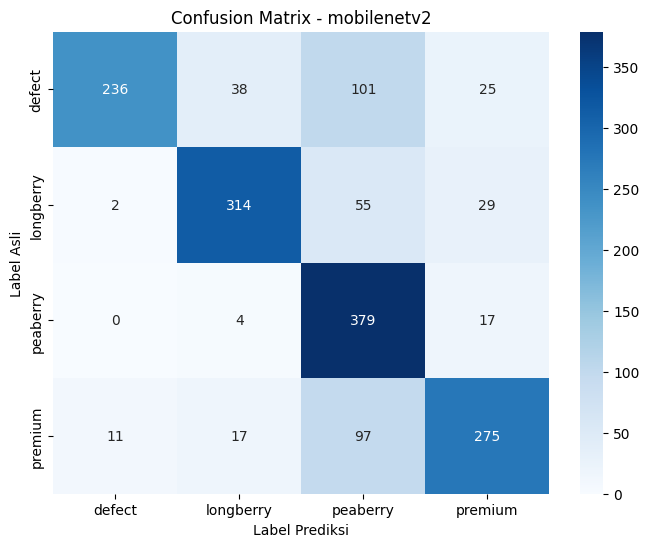

In [23]:
# Plot Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.title(f'Confusion Matrix - {m_type}')
plt.show()

## Resnet

In [24]:
# --- KONFIGURASI KHUSUS CELL INI ---
m_type = 'resnet50v2'
print(f"\n{'='*40}")
print(f" TRAINING MODEL: {m_type.upper()} ")
print(f"{'='*40}")

# 1. Build Model
model = build_model(m_type, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)


 TRAINING MODEL: RESNET50V2 


In [25]:
model.summary()

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [26]:
# 2. Train Model
print("Memulai training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

Memulai training...
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 512ms/step - accuracy: 0.4829 - loss: 1.4302 - val_accuracy: 0.6669 - val_loss: 0.8451
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 516ms/step - accuracy: 0.6081 - loss: 0.9967 - val_accuracy: 0.6944 - val_loss: 0.7701
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 544ms/step - accuracy: 0.6621 - loss: 0.8614 - val_accuracy: 0.7075 - val_loss: 0.7694
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 470ms/step - accuracy: 0.6873 - loss: 0.8139 - val_accuracy: 0.7069 - val_loss: 0.7512
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 424ms/step - accuracy: 0.6971 - loss: 0.7683 - val_accuracy: 0.6950 - val_loss: 0.7720
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - accuracy: 0.7117 - loss: 0.7512 - val_accuracy: 0.7156 - val_loss: 0.7159
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 424ms/step - accuracy: 0.7206 - loss: 0.7131 - val_accuracy: 0.7075 - val_loss: 0.7507
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 421ms/step - accura

In [27]:
# --- BAGIAN BARU: SIMPAN HISTORY KE CSV ---
history_df = pd.DataFrame(history.history)
csv_name = f"history_{m_type}.csv"
history_df.to_csv(csv_name, index=False)
print(f"📈 History training berhasil disimpan ke: {csv_name}")

📈 History training berhasil disimpan ke: history_resnet50v2.csv


In [28]:
# 3. Save Model
save_path = f"model_{m_type}.keras"
model.save(save_path)
print(f"💾 Model berhasil disimpan ke: {save_path}")

💾 Model berhasil disimpan ke: model_resnet50v2.keras


In [29]:
# 4. Evaluasi
print(f"\nEvaluasi Model {m_type} pada Data Test...")
test_generator.reset()
Y_pred = model.predict(test_generator, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))


Evaluasi Model resnet50v2 pada Data Test...

Classification Report:
              precision    recall  f1-score   support

      defect       0.92      0.60      0.73       400
   longberry       0.94      0.78      0.85       400
    peaberry       0.67      0.88      0.76       400
     premium       0.67      0.80      0.73       400

    accuracy                           0.77      1600
   macro avg       0.80      0.77      0.77      1600
weighted avg       0.80      0.77      0.77      1600



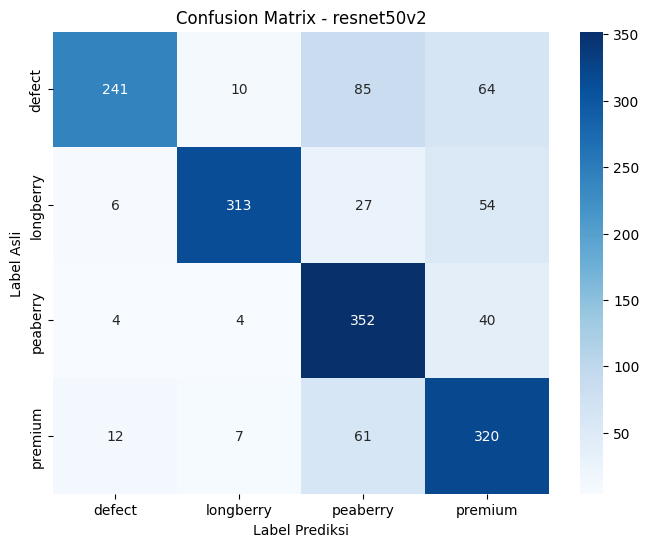

In [30]:
# Plot Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.title(f'Confusion Matrix - {m_type}')
plt.show()